## 参考:
https://www.cnblogs.com/wsine/p/5180778.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import time
UNCLASSIFIED = False
NOISE = 0

In [2]:
def loadDataSet(fileName, splitChar='\t'):
    """
    Description:load data to a list
    Parameters:
        fileName:
        splitChar:
    Return:
        a list with data
    """
    dataSet = []
    with open(fileName) as f:
        for line in f.readlines():
            curline = line.strip().split(splitChar)
            fltline = list(map(float, curline))
            dataSet.append(fltline)
    return dataSet    

In [3]:
def dist(a,b):
    """
    Description: calculate euclidean distance
    Parameters:
        a, b - two vectors
    Return:
        euclidean distance
    """
    return math.sqrt(np.power(a-b,2).sum())

In [4]:
def eps_neighbor(a,b, eps):
    """
    Description:check if ab is neighbor in eps distance
    Parameters:
        a,b - vectors
        eps - distance threshold
    Return: boolean
    """
    return dist(a,b) < eps

In [5]:
def region_query(data, pointId, eps):
    """
    Description:search for points that in eps distance of pointId in data
    Parameters:
        data - search from data
        pointId - core point index
        eps - distance
    Return:
        index of all points in eps distance of core point pointId
    """
    nPoints = data.shape[1]
    seeds = []
    for i in range(nPoints):
        if eps_neighbor(data[:, pointId], data[:, i],eps):
            seeds.append(i)
    return seeds

In [16]:
def expand_cluster(data, clusterResult, pointId, clusterId, eps, minPts):
    """
    Description: expand cluster for core pointId
    Parameters:
        data - training data set
        clusterResult - cluster result with data index, same size with data
        pointId - core point index
        clusterId - id of cluster to be expanded
        eps - distance
        minPts - min neighbor points for core point
    Return:
        True - expand succeed
        False - pointId is a NOISE
    """
    seeds = region_query(data, pointId, eps)
    if len(seeds) < minPts: 
        clusterResult[pointId] = NOISE
        return False
    else:
        clusterResult[pointId] = clusterId
        for seed in seeds:
            clusterResult[seed] = clusterId
            
    while len(seeds) > 0:   #keep expanding
        currentPoint = seeds[0]
        queryResults = region_query(data, currentPoint, eps)
        if len(queryResults) >= minPts:
            for i in range(len(queryResults)):
                resultPoint = queryResults[i]
                if clusterResult[resultPoint] == UNCLASSIFIED:
                    seeds.append(resultPoint)
                    clusterResult[resultPoint] = clusterId
                elif clusterResult[resultPoint] == NOISE:
                    clusterResult[resultPoint] = clusterId
        seeds = seeds[1:]
    return True          

In [17]:
def dbscan(data, eps, minPts):
    """
    Description:dbscan clustering algorithm
    Parameters:
        data - training data set
        eps - distance
        minPts - 
    Return:
        clusterResult - clustered data set
        clusters - clustered clusters
    """
    clusterId = 1
    nPoints = data.shape[1]
    clusterResult = [UNCLASSIFIED] * nPoints
    for pointId in range (nPoints):
        point = data[:,pointId]
        if clusterResult[pointId] == UNCLASSIFIED:
            if expand_cluster(data, clusterResult, pointId, clusterId, eps, minPts):
                clusterId = clusterId + 1
    return clusterResult, clusterId - 1

In [59]:
def saveResults(clusterResult, filename):
    np.savetxt(filename, clusterResult, delimiter=',')    

In [85]:
def plotCluster(data, clusters, clusterNum):
    nPoints = data.shape[1]
    matClusters = np.mat(clusters).transpose()
    print(matClusters[:10])
    fig = plt.figure()
    scatterColors = ["black","blue", "green", "yellow", "red", "purple", "orange", "brown"]
    ax = fig.add_subplot(111)
    for i in range(clusterNum+1):
        colorStyle = scatterColors[i % len(scatterColors)]
        subCluster = data[:, np.nonzero(matClusters[:, 0].A == i)[:-1]] # do i need to add [0]?
        if i == 7:
            print(data.shape)
            print(subCluster.shape)
            print(subCluster)
            print(subCluster[0, :].flatten())
        ax.scatter(subCluster[0, :].flatten().A[0], subCluster[1, :].flatten().A[0], c=colorStyle, s=50)
    plt.show()

In [86]:
def main():
    dataSet = loadDataSet("788points.txt", splitChar=",")
    dataSet = np.mat(dataSet).transpose()
    print(dataSet[:, :10])
    clusterResult, clusterNum = dbscan(dataSet, 2, 15)
    saveResults(clusterResult, "788Results.txt")
    print("cluster Numbers = ", clusterNum)
    print(clusterResult[:10])
    plotCluster(dataSet, clusterResult, clusterNum)

[[ 15.55  14.9   14.45  14.15  13.75  13.35  13.    13.45  13.6   12.8 ]
 [ 28.65  27.55  28.35  28.8   28.05  28.45  29.15  27.5   26.5   27.35]]
cluster Numbers =  7
[0, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[[0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]]
(2, 788)
(2, 1, 34)
[[[ 5.2   6.35  6.75  5.9   5.4   4.85  4.85  5.15  5.7   6.2   6.2   7.65
    7.2   6.75  6.75  6.65  5.8   4.95  5.1   5.7   5.45  6.7   6.55  7.2
    6.2   7.1   7.85  7.6   7.25  7.8   8.05  8.5   8.1   8.15]]

 [[ 2.15  1.95  2.3   2.4   2.7   2.9   3.35  3.45  3.45  3.    3.2   2.15
    2.75  3.2   3.55  3.8   4.    4.05  4.35  4.45  4.85  4.8   5.05  4.9
    4.25  4.3   4.5   4.15  3.55  3.35  2.75  3.25  3.55  4.  ]]]
[[ 5.2   6.35  6.75  5.9   5.4   4.85  4.85  5.15  5.7   6.2   6.2   7.65
   7.2   6.75  6.75  6.65  5.8   4.95  5.1   5.7   5.45  6.7   6.55  7.2
   6.2   7.1   7.85  7.6   7.25  7.8   8.05  8.5   8.1   8.15]]


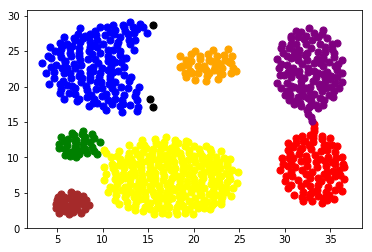

finish in 23.974304522708735 


In [87]:
if __name__ == "__main__":
    start = time.clock()
    main()
    end = time.clock()
    print("finish in %s " % str(end-start))